# A simple demonstration: Physics-based Learning
**Author:** Michael Kellman

**Date:** April 17th 2020

In [2]:
%matplotlib notebook

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.sparse import random as srand
from matplotlib import pyplot as plt
import time

dtype = torch.float32
#device = torch.device('cpu')
device = torch.device('cuda:0')

## Setup Sparse Vector Dataset

In [3]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X)
    
    def __getitem__(self, i):
        return self.X[i, ...]
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x

## Setup the system

$ \mathbf{y} = \mathbf{A}(\mathbf{x}) + \mathbf{n}$ where $\mathbf{x}$ is sparse and $\mathbf{A}$ is an under-determined system.

In [4]:
def Aop(A, x):
    # Aop - Forward model process
    # args in -
    #   A - measurement matrix
    #   x - input vector
    return torch.matmul(A,x)

def softthr(x, thr):
    # softthr - Soft thresholding operator
    # args in -
    #   x - input vector
    #   thr - shrinkage threshold
    # args out - 
    #   z - output vector
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * (torch.abs(x) > thr)
    return z

## Physics-based Network

$\mathbf{x}^\star = \arg\underset{\mathbf{x}}{\min} \ \|\mathbf{A}(\mathbf{x}) - \mathbf{y}\|^2 + \lambda \|\mathbf{x}\|_1$

The physics-based network is constructed by unrolling $K$ iterations of this objectives optimizer (in this example proximal gradient descent or iterative soft thresholding algorithm).

In [5]:
def pbnet(A, alpha, lamb, x0, xt, K, testFlag=True, explicit_grad=True):
    # pbnet - Physics-based Network
    # args in - 
    #   A - measurement matrix
    #   alpha - step size
    #   lamb - sparsity penalty
    #   x0 - initialization
    #   xt - ground truth sparse vector
    #   K - number of layers (i.e. iterations)
    #   testFlag - disables training (default True)
    # args out - 
    #   x - output of network (final estimate)

    x = x0.detach().clone()
    x.requires_grad = True

    y_meas = Aop(A, xt)
    
    if explicit_grad:
        AHA = torch.matmul(torch.transpose(A, 0, 1), A)
        AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)

    if testFlag: y_meas = y_meas.detach()
    
    losslist = []
        
    for kk in range(K):
        y_est = Aop(A,x)
        res = y_est - y_meas
        loss_dc = torch.sum(res**2)
        if explicit_grad:
            g = torch.matmul(AHA, x) - AHy
        else:
            g = torch.autograd.grad(loss_dc, 
                                    x, 
                                    create_graph = not testFlag)[0]
        
        x = x - alpha*g           # gradient update
        x = softthr(x, lamb*alpha)   # proximal update
        
        with torch.no_grad():
            loss = loss_dc + thr * torch.sum(torch.abs(x))
            losslist.append(loss.cpu().detach().numpy())
    return x, losslist

## Test reconstruction (network inference)

In [6]:
Np = [70, 100] # measurement matrix dimensions
sparsity_level = 6 # sparsity level
dataset = sparse_dataset(Np[1], sparsity_level, 1)
xt = dataset[0]

A = torch.from_numpy(np.random.randn(Np[0], Np[1]))
emax = np.max(abs(np.linalg.eig(A.T @ A)[0]))

x_init = torch.from_numpy(np.random.randn(Np[1], 1))
x0 = x_init.detach().clone()

### Run network to convergence
First run the network with enough iterations to reach convergence (good result)

alpha: 0.0030339559413446924
elapsed time:  3.729604959487915


<IPython.core.display.Javascript object>


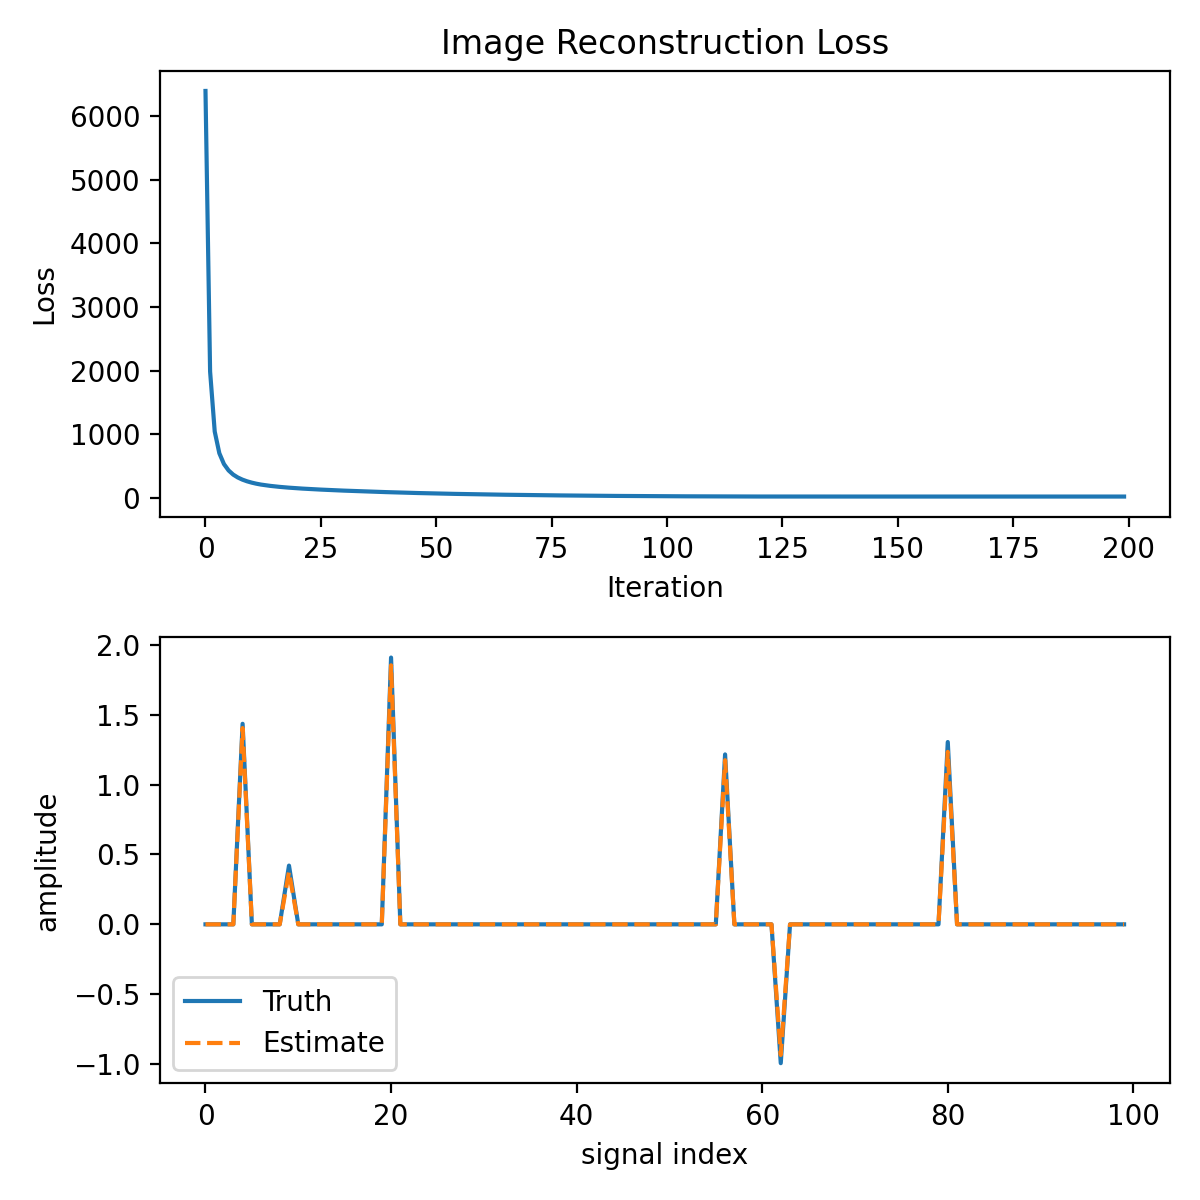

In [7]:
max_iter = 200
alpha = .95
thr = 3.5

alpha /= emax
print('alpha:', alpha)


tic = time.time()
x_est, losslist = pbnet(A.to(device), alpha, thr, x0.to(device), xt.to(device), max_iter, testFlag=True)
print('elapsed time: ', time.time()-tic)

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(losslist)
plt.title('Image Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.subplot(212)
plt.plot(xt.detach().cpu().numpy(), label='Truth')
plt.plot(x_est.detach().cpu().numpy(), '--', label='Estimate')
plt.xlabel('signal index')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()

### Test with limited number of iterations
Compare to output with limited number of iterations (bad result)

alpha: 0.0030339559413446924
elapsed time:  0.02227306365966797


<IPython.core.display.Javascript object>


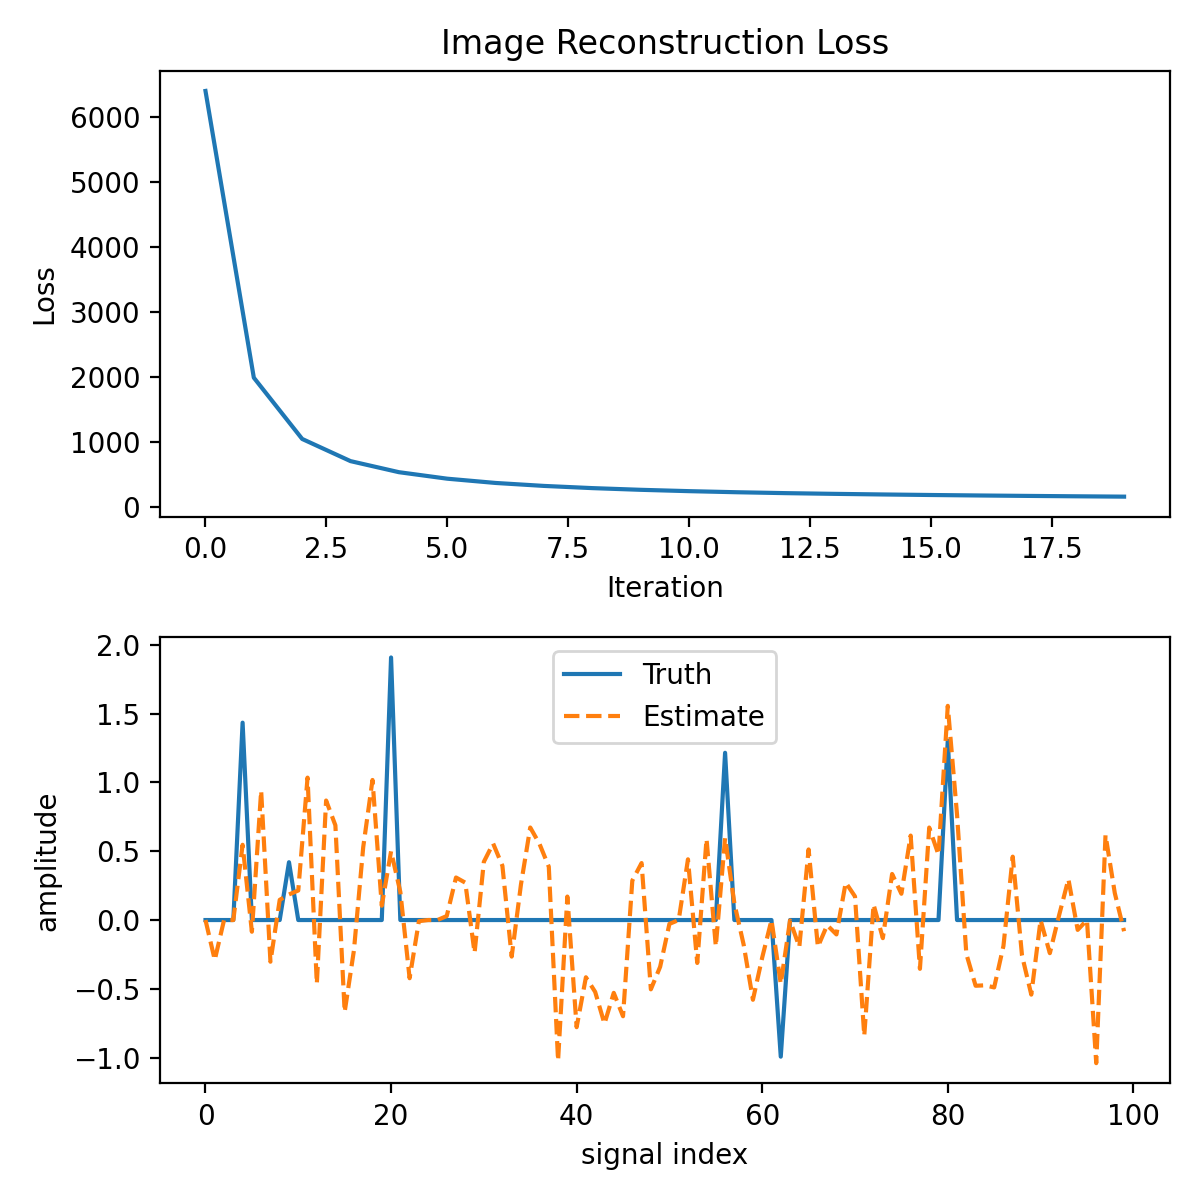

In [8]:
max_iter = 20
alpha = .95
thr = 3.5

alpha /= emax
print('alpha:', alpha)


tic = time.time()
x_est, losslist = pbnet(A.to(device), alpha, thr, x0.to(device), xt.to(device), max_iter, testFlag=True)
print('elapsed time: ', time.time()-tic)

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(losslist)
plt.title('Image Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.subplot(212)
plt.plot(xt.detach().cpu().numpy(), label='Truth')
plt.plot(x_est.detach().cpu().numpy(), '--', label='Estimate')
plt.xlabel('signal index')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()

## Setup learning
Learn best alpha, lambda, and A matrix for limited-iterations setting

In [9]:
A_init =  torch.from_numpy(np.random.randn(Np[0], Np[1])).to(device)
A = A_init.detach().clone()
A.requires_grad = True

alpha_init = torch.from_numpy(np.array(0.002)).to(device)
alpha = alpha_init.detach().clone()
alpha.requires_grad = True

thr_init = torch.from_numpy(np.array(3.5)).to(device)
thr = thr_init.detach().clone()
thr.requires_grad = True


Nepochs = 20
Nbatchsize = 10
Testfreq = 1

Ntraining = 100
Ntesting = 10
dataset_training = sparse_dataset(Np[1], sparsity_level, Ntraining)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = Nbatchsize, shuffle=True)

dataset_testing = sparse_dataset(Np[1], sparsity_level, Ntesting)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = 1, shuffle=False)

learning_optim = torch.optim.Adam([
                                  {'params' : [A], 'lr' : 1e-3},
                                  {'params' : [thr], 'lr' : 1e-4},
                                  {'params' : [alpha], 'lr' : 1e-4}
])


Nbatches = int(Ntraining/Nbatchsize)
training_losslist = np.zeros(Nepochs * Nbatches)
testing_losslist = np.zeros(Nepochs * Nbatches)

## Training

In [10]:
for tt in range(Nepochs):
    for kk, Xs in enumerate(dataloader_training):
        learning_idx = tt * Nbatches + kk
        for ss in range(Nbatchsize):
            xt = Xs[ss, ...].to(device)
            x0 = x_init.detach().clone().to(device)
            x_est, _ = pbnet(A, alpha, thr, x0, xt, max_iter, testFlag=False)
            training_loss = torch.mean((x_est - xt)**2)
            training_loss.backward()
            
            with torch.no_grad():
                training_losslist[learning_idx] += training_loss

        learning_optim.step()
        learning_optim.zero_grad()

        if learning_idx % Testfreq == 0:
            for ff, xt in enumerate(dataloader_testing):
                x0 = x_init.detach().clone().to(device)
                x_est, _ = pbnet(A.detach(), alpha.detach(), thr.detach(), x0, xt[0,...].to(device), max_iter, testFlag=True)
                testing_losslist[learning_idx] += torch.mean((x_est.cpu() - xt[0,...])**2)
            print(tt, kk, training_losslist[learning_idx], testing_losslist[learning_idx], end='\r')

## Display results

<IPython.core.display.Javascript object>


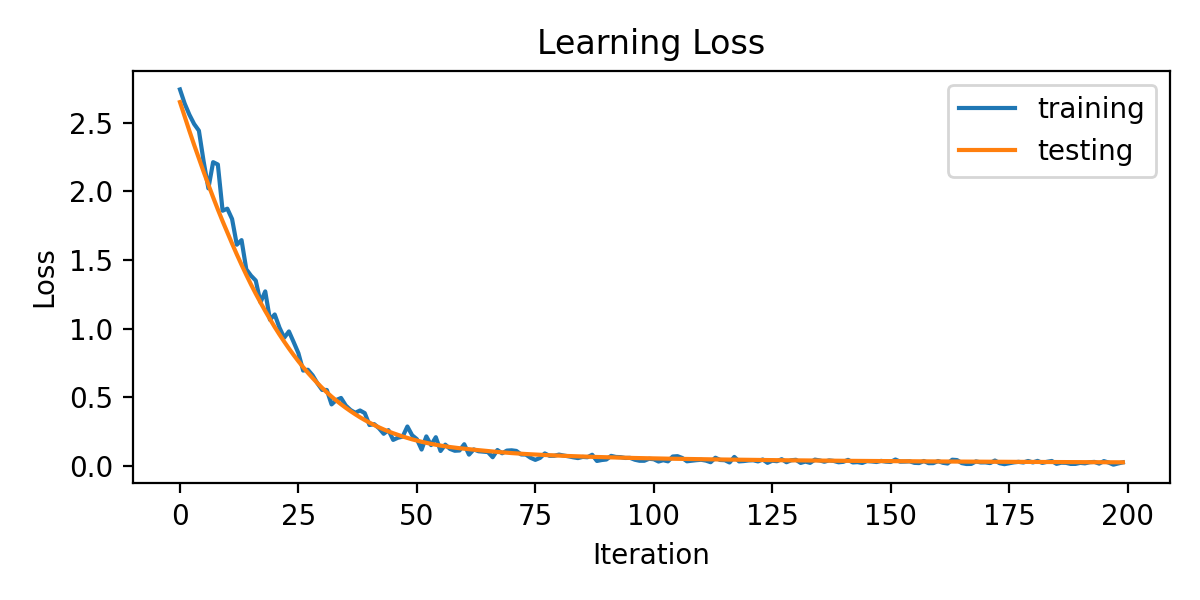

<IPython.core.display.Javascript object>


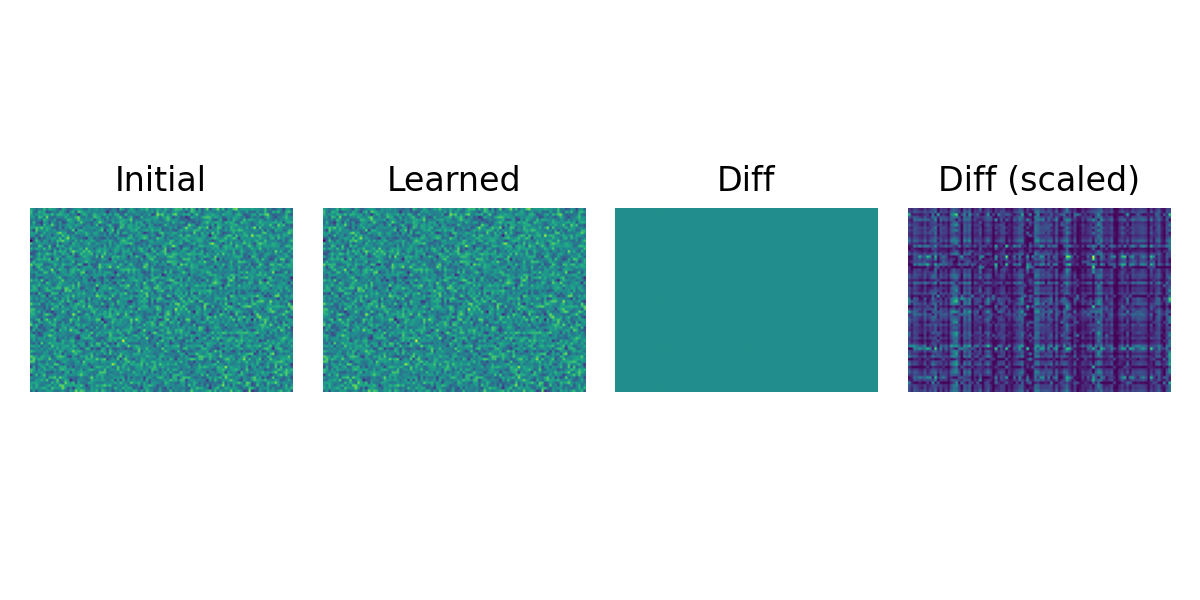

Initial threshold: 3.500000
Learned threshold: 3.507806
Initial step size: 0.002000
Learned step size: 0.006821
Initial A norm: 83.535285
Learned A norm: 83.347584


<IPython.core.display.Javascript object>


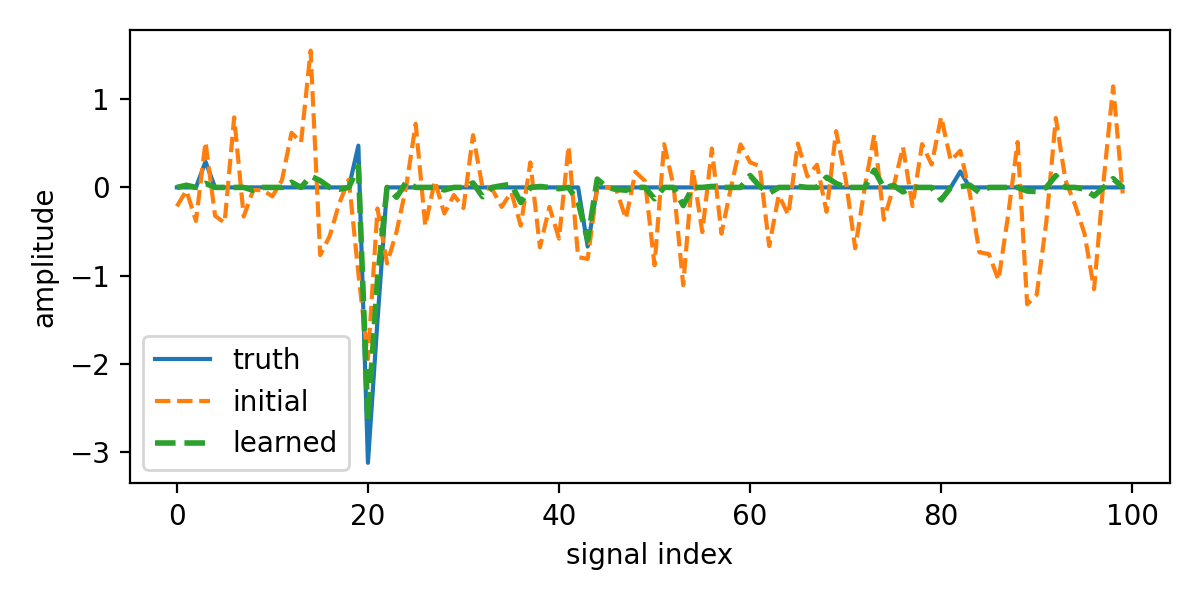

In [11]:
xt = dataset_testing[1]
Aopt = A.cpu().detach().numpy()
x_est_opt, _ = pbnet(A.to(device), alpha, thr, x0.to(device), xt.to(device), max_iter, testFlag=True)
x_est_init, _ = pbnet(A_init.to(device), alpha_init, thr_init, x0.to(device), xt.to(device), max_iter, testFlag=True)

plt.figure(figsize=(6,3))
plt.plot(training_losslist, label='training')
plt.plot(testing_losslist, label='testing')
plt.title('Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.tight_layout()
plt.legend()

vmin = np.min(Aopt)
vmax = np.max(Aopt)
plt.figure(figsize=(6,3))
plt.subplot(141)
plt.imshow(A_init.cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.title('Initial')
plt.axis('off')
plt.subplot(142)
plt.imshow(Aopt, vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Learned')
plt.subplot(143)
plt.imshow((A_init.cpu().numpy() - Aopt)**2, vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Diff')
plt.tight_layout()
plt.subplot(144)
plt.imshow((A_init.cpu().numpy() - Aopt)**2)
plt.axis('off')
plt.title('Diff (scaled)')
plt.tight_layout()

print('Initial threshold: %f' % thr_init.cpu().detach().numpy())
print('Learned threshold: %f' % thr.cpu().detach().numpy())

print('Initial step size: %f' % alpha_init.cpu().detach().numpy())
print('Learned step size: %f' % alpha.cpu().detach().numpy())

print('Initial A norm: %f' % np.linalg.norm(A_init.cpu().detach().numpy()))
print('Learned A norm: %f' % np.linalg.norm(Aopt))

plt.figure(figsize=(6,3))
plt.plot(xt.detach().cpu().numpy(), label='truth')
plt.plot(x_est_init.detach().cpu().numpy(), '--', label='initial')
plt.plot(x_est_opt.detach().cpu().numpy(), '--', label='learned', linewidth=2)

plt.xlabel('signal index')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()

## More testing examples

<IPython.core.display.Javascript object>


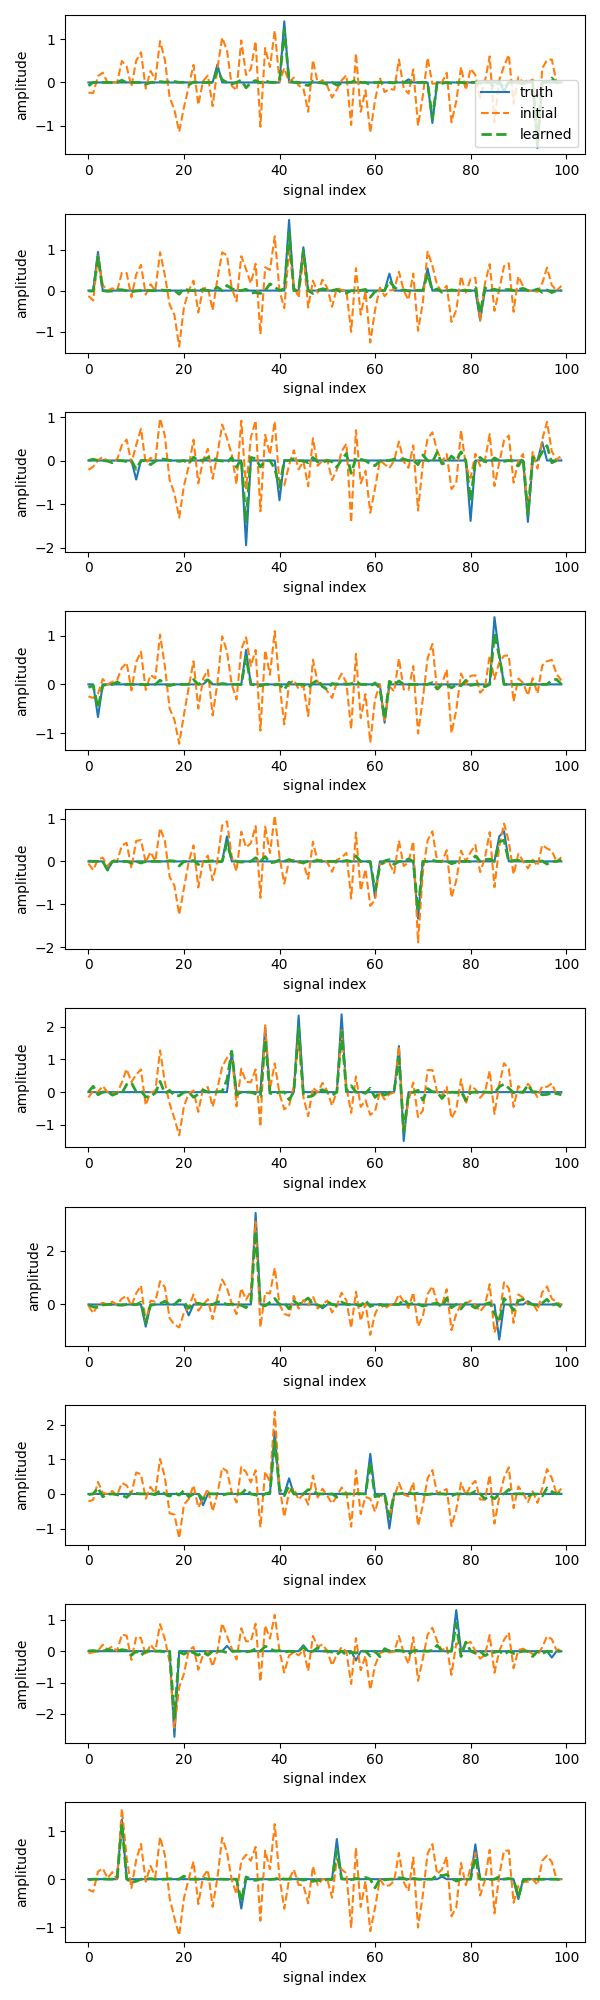

In [11]:
plt.figure(figsize=(6,2*Ntesting))
for ii in range(Ntesting):
    plt.subplot(Ntesting, 1, ii + 1)
    
    xt = dataset_testing[ii].to(device)
    x_est_opt, _ = pbnet(A, alpha, thr, x0, xt, max_iter, testFlag=True)
    x_est_init, _ = pbnet(A_init, alpha_init, thr_init, x0, xt, max_iter, testFlag=True)


    plt.plot(xt.detach().cpu().numpy(), label='truth')
    plt.plot(x_est_init.detach().cpu().numpy(), '--', label='initial')
    plt.plot(x_est_opt.detach().cpu().numpy(), '--', label='learned', linewidth=2)
    plt.xlabel('signal index')
    plt.ylabel('amplitude')
    if ii is 0: plt.legend()
plt.tight_layout()